<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1 
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [336]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Cross validation 
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import cross_val_score

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [52]:
# ANSWER
titanic_csv = 'dat/titanic_train.csv'
ori_data = pd.read_csv(titanic_csv)
cleansed_dat = pd.DataFrame(ori_data)

Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find candidate features to predict `Survived`. Get rid of null values. 

In [36]:
# ANSWER
ori_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [37]:
ori_data.duplicated().sum()

0

In [38]:
ori_data.Age.unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

In [53]:
cleansed_dat.Age = cleansed_dat.Age.fillna(ori_data.Age.mean())
cleansed_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [56]:
cleansed_dat.Age = round(cleansed_dat.Age, 1)
cleansed_dat.Age.unique()

array([22. , 38. , 26. , 35. , 29.7, 54. ,  2. , 27. , 14. ,  4. , 58. ,
       20. , 39. , 55. , 31. , 34. , 15. , 28. ,  8. , 19. , 40. , 66. ,
       42. , 21. , 18. ,  3. ,  7. , 49. , 29. , 65. , 28.5,  5. , 11. ,
       45. , 17. , 32. , 16. , 25. ,  0.8, 30. , 33. , 23. , 24. , 46. ,
       59. , 71. , 37. , 47. , 14.5, 70.5, 32.5, 12. ,  9. , 36.5, 51. ,
       55.5, 40.5, 44. ,  1. , 61. , 56. , 50. , 36. , 45.5, 20.5, 62. ,
       41. , 52. , 63. , 23.5,  0.9, 43. , 60. , 10. , 64. , 13. , 48. ,
       53. , 57. , 80. , 70. , 24.5,  6. ,  0.7, 30.5,  0.4, 34.5, 74. ])

In [57]:
cleansed_dat.Fare = round(cleansed_dat.Fare, 2)
cleansed_dat.Fare.unique()

array([  7.25,  71.28,   7.92,  53.1 ,   8.05,   8.46,  51.86,  21.08,
        11.13,  30.07,  16.7 ,  26.55,  31.28,   7.85,  16.  ,  29.12,
        13.  ,  18.  ,   7.22,  26.  ,   8.03,  35.5 ,  31.39, 263.  ,
         7.88,   7.9 ,  27.72, 146.52,   7.75,  10.5 ,  82.17,  52.  ,
         7.23,  11.24,   9.48,  21.  ,  41.58,  15.5 ,  21.68,  17.8 ,
        39.69,   7.8 ,  76.73,  61.98,  27.75,  46.9 ,  80.  ,  83.48,
        27.9 ,  15.25,   8.16,   8.66,  73.5 ,  14.45,  56.5 ,   7.65,
        29.  ,  12.48,   9.  ,   9.5 ,   7.79,  47.1 ,  15.85,  34.38,
        61.18,  20.58,  34.65,  63.36,  23.  ,  77.29,   8.65,   7.78,
        24.15,   9.82,  14.46, 247.52,   7.14,  22.36,   6.98,   7.05,
        14.5 ,  15.05,  26.28,   9.22,  79.2 ,   6.75,  11.5 ,  36.75,
        12.52,  66.6 ,   7.31,  61.38,   7.73,  69.55,  16.1 ,  15.75,
        20.52,  55.  ,  25.92,  33.5 ,  30.7 ,  25.47,  28.71,   0.  ,
        39.  ,  22.02,  50.  ,   8.4 ,   6.5 ,  10.46,  18.79,  31.  ,
      

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [71]:
# ANSWER
# target
y = cleansed_dat['Survived']
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [ ]:
# features
#X = cleansed_dat.drop(['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Ticket', 'Fare', 'Cabin acidity', 'Embarked'],axis=1)
#X

In [69]:
X = cleansed_dat[['Pclass', 'Parch']]
X

,Pclass,Parch
0,3,0
1,1,0
2,3,0
3,1,0
4,3,0
...,...,...
886,2,0
887,1,0
888,3,2
889,1,0


#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [72]:
# ANSWER
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [106]:
# ANSWER
# Create Model
log_res = LogisticRegression()

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [107]:
# ANSWER
# Fit Model
log_res.fit(X_train, y_train)

LogisticRegression()

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [78]:
# ANSWER
log_res.coef_

array([[-0.81700963,  0.22899575]])

The computed intercept (`intercept_`) is the 1st element of another array:

In [79]:
# ANSWER
log_res.intercept_

array([1.26711301])

We can create tuples of the predictor names and coefficients like this:

In [81]:
# ANSWER
print(set(zip(X, log_res.coef_[0])))

{('Parch', 0.22899574866665665), ('Pclass', -0.8170096344080916)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [83]:
for col in zip(X_train.columns, log_res.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.817010
Parch       +0.228996


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [108]:
# ANSWER
y_pred_train = log_res.predict(X_train)
metrics.accuracy_score(y_train, y_pred_train)

0.6966292134831461

What is the  `accuracy_score` for the test data?

In [109]:
# ANSWER
y_pred_test = log_res.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.7597765363128491

What can we say aout this result?

ANSWER
- ...
- ...

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model

In [110]:
# ANSWER
X = cleansed_dat[['Pclass', 'Parch', 'Age']]
X

,Pclass,Parch,Age
0,3,0,22.0
1,1,0,38.0
2,3,0,26.0
3,1,0,35.0
4,3,0,35.0
...,...,...,...
886,2,0,27.0
887,1,0,19.0
888,3,2,29.7
889,1,0,26.0


In [112]:
# Build Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = LogisticRegression()

# Fit Model
model.fit(X_train,y_train)

# Score
y_pred_train = model.predict(X_train)
print('Training set score: ', metrics.accuracy_score(y_train, y_pred_train))

y_pred_test = model.predict(X_test)
print('Test set score: ', metrics.accuracy_score(y_test, y_pred_test))

Training set score:  0.6966292134831461
Test set score:  0.7597765363128491


So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- ...
- ...
- ...

Let's see where the model is going wrong by showing the Confusion Matrix:

In [113]:
# ANSWER
y_pred_class = model.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[94 11]
 [32 42]]


Nb. Here is how `confusion_matrix` arranges its output:

In [0]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: ...

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

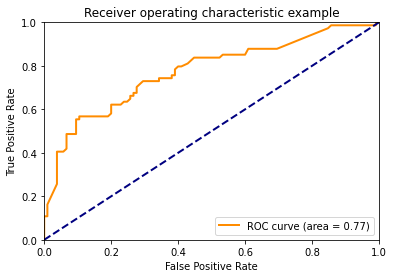

In [114]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = model.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [116]:
titanic_with_dummies = pd.get_dummies(data = ori_data, columns = ['Sex', 'Embarked', 'Pclass'], 
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.25,NaN,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.28,C85,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.92,NaN,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.10,C123,1,0,0,0,1,1,0,0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.05,NaN,0,1,0,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first vriable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [126]:
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))

In [127]:
titanic_with_dummies

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.25,NaN,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.28,C85,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.92,NaN,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.10,C123,1,0,0,0,1,1,0,0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.05,NaN,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,"Montvila, Rev. Juozas",27.0,0,0,211536,13.00,NaN,0,1,0,0,1,0,1,0
887,888,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.00,B42,1,0,0,0,1,1,0,0
888,889,0,"Johnston, Miss. Catherine Helen ""Carrie""",29.7,1,2,W./C. 6607,23.45,NaN,1,0,0,0,1,0,0,1
889,890,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.00,C148,0,1,1,0,0,1,0,0


Now train the model using an expanded set of predictors (age, parents/children, siblings/spouses, class) and compute the accuracy score for the test set:

In [278]:
# ANSWER
# Set Features with both Numerical and the above specified Categorical features
X = titanic_with_dummies[["Age", "Parch", "SibSp", "Pclass_1", "Pclass_2", "Pclass_3"]]
X

,Age,Parch,SibSp,Pclass_1,Pclass_2,Pclass_3
0,22.0,0,1,0,0,1
1,38.0,0,1,1,0,0
2,26.0,0,0,0,0,1
3,35.0,0,1,1,0,0
4,35.0,0,0,0,0,1
...,...,...,...,...,...,...
886,27.0,0,0,0,1,0
887,19.0,0,0,1,0,0
888,29.7,2,1,0,0,1
889,26.0,0,0,1,0,0


In [184]:
# Build Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = LogisticRegression()

# Fit Model
model.fit(X_train,y_train)

# Score
y_pred_train = model.predict(X_train)
print('Training set score: ', model.score(X_train, y_train))

y_pred_test = model.predict(X_test)
print('Test set score: ', model.score(X_test, y_test))

Training set score:  0.6825842696629213
Test set score:  0.7262569832402235


Plot the ROC curve for the new model:

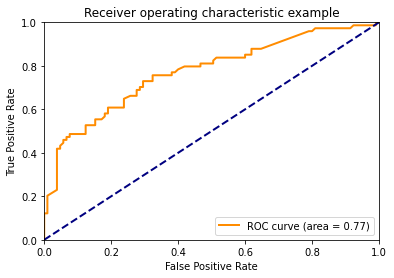

In [185]:
# ANSWER
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = model.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

# With Sex added

Can we improve the model by including the remaining features?

In [277]:
# ANSWER
X = titanic_with_dummies[["Age", "Parch", "SibSp", "Sex_male", "Sex_female", "Pclass_1", "Pclass_2", "Pclass_3"]]
X

,Age,Parch,SibSp,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3
0,22.0,0,1,1,0,0,0,1
1,38.0,0,1,0,1,1,0,0
2,26.0,0,0,0,1,0,0,1
3,35.0,0,1,0,1,1,0,0
4,35.0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...
886,27.0,0,0,1,0,0,1,0
887,19.0,0,0,0,1,1,0,0
888,29.7,2,1,0,1,0,0,1
889,26.0,0,0,1,0,1,0,0


In [213]:
# Build Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = LogisticRegression()

# Fit Model
model.fit(X_train,y_train)

# Score
y_pred_train = model.predict(X_train)
print('Training set score: ', model.score(X_train, y_train))

y_pred_test = model.predict(X_test)
print('Test set score: ', model.score(X_test, y_test))

Training set score:  0.800561797752809
Test set score:  0.8156424581005587


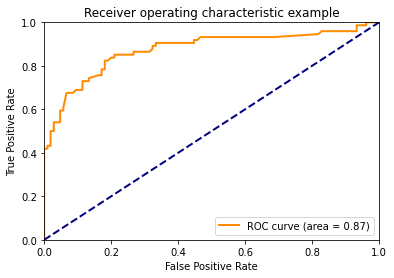

In [214]:
# ANSWER
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = model.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

# With Embarked added

In [229]:
# ANSWER
X = titanic_with_dummies[["Age", "Parch", "SibSp", "Sex_male", "Sex_female", "Embarked_C", "Embarked_Q", "Embarked_S", "Pclass_1", "Pclass_2", "Pclass_3"]]
X

,Age,Parch,SibSp,Sex_male,Sex_female,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,0,1,1,0,0,0,1,0,0,1
1,38.0,0,1,0,1,1,0,0,1,0,0
2,26.0,0,0,0,1,0,0,1,0,0,1
3,35.0,0,1,0,1,0,0,1,1,0,0
4,35.0,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,1,0,0,0,1,0,1,0
887,19.0,0,0,0,1,0,0,1,1,0,0
888,29.7,2,1,0,1,0,0,1,0,0,1
889,26.0,0,0,1,0,1,0,0,1,0,0


In [237]:
# Build Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = LogisticRegression()

# Fit Model
model.fit(X_train,y_train)

# Score
y_pred_train = model.predict(X_train)
print('Training set score: ', model.score(X_train, y_train))

y_pred_test = model.predict(X_test)
print('Test set score: ', model.score(X_test, y_test))

Training set score:  0.8019662921348315
Test set score:  0.8044692737430168


F:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


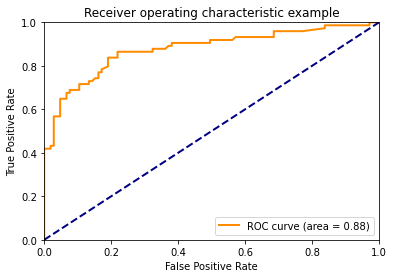

In [238]:
# ANSWER
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = model.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

# With Fare added

In [239]:
# ANSWER
X = titanic_with_dummies[["Age", "Parch", "Fare", "SibSp", "Sex_male", "Sex_female", "Embarked_C", "Embarked_Q", "Embarked_S", "Pclass_1", "Pclass_2", "Pclass_3"]]
X

,Age,Parch,Fare,SibSp,Sex_male,Sex_female,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,0,7.25,1,1,0,0,0,1,0,0,1
1,38.0,0,71.28,1,0,1,1,0,0,1,0,0
2,26.0,0,7.92,0,0,1,0,0,1,0,0,1
3,35.0,0,53.10,1,0,1,0,0,1,1,0,0
4,35.0,0,8.05,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,13.00,0,1,0,0,0,1,0,1,0
887,19.0,0,30.00,0,0,1,0,0,1,1,0,0
888,29.7,2,23.45,1,0,1,0,0,1,0,0,1
889,26.0,0,30.00,0,1,0,1,0,0,1,0,0


In [240]:
# Build Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = LogisticRegression()

# Fit Model
model.fit(X_train,y_train)

# Score
y_pred_train = model.predict(X_train)
print('Training set score: ', model.score(X_train, y_train))

y_pred_test = model.predict(X_test)
print('Test set score: ', model.score(X_test, y_test))

Training set score:  0.8061797752808989
Test set score:  0.7988826815642458


F:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


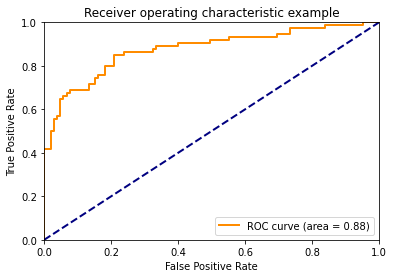

In [241]:
# ANSWER
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = model.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?  
Tip : consult sklearn cross_val_score

3. Look at the False Positive Rate `FPR` & True Positive Rate `TPR` vectors for the best model.

In [279]:
y = cleansed_dat[['Survived']]

In [309]:
#X = cleansed_dat[['Pclass', 'Parch', 'Age']]
#X = titanic_with_dummies[["Age", "Parch", "SibSp", "Pclass_1", "Pclass_2", "Pclass_3"]]
X = titanic_with_dummies[["Age", "Parch", "SibSp", "Sex_male", "Sex_female", "Pclass_1", "Pclass_2", "Pclass_3"]]
#X = titanic_with_dummies[["Age", "Parch", "SibSp", "Sex_male", "Sex_female", "Embarked_C", "Embarked_Q", "Embarked_S", "Pclass_1", "Pclass_2", "Pclass_3"]]
#X = titanic_with_dummies[["Age", "Parch", "Fare", "SibSp", "Sex_male", "Sex_female", "Embarked_C", "Embarked_Q", "Embarked_S", "Pclass_1", "Pclass_2", "Pclass_3"]]

# Sklearn cross_validate()

In [318]:
# Build Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
model = LogisticRegression()

# Fit Model
model.fit(X_train,y_train)

# Score
y_pred_train = model.predict(X_train)
print('Training set score: ', model.score(X_train, y_train))

y_pred_test = model.predict(X_test)
print('Test set score: ', model.score(X_test, y_test))

Training set score:  0.7963483146067416
Test set score:  0.8324022346368715


F:\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


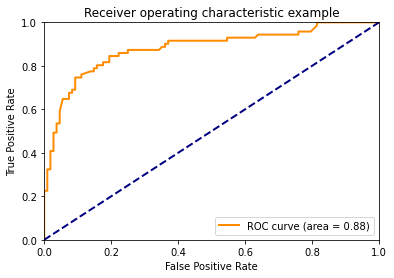

In [319]:
# Plot the ROC curve
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = model.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [320]:
metrics.SCORERS

{'explained_variance': make_scorer(explained_variance_score),
 'r2': make_scorer(r2_score),
 'max_error': make_scorer(max_error, greater_is_better=False),
 'neg_median_absolute_error': make_scorer(median_absolute_error, greater_is_better=False),
 'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
 'neg_mean_absolute_percentage_error': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
 'neg_mean_squared_log_error': make_scorer(mean_squared_log_error, greater_is_better=False),
 'neg_root_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
 'neg_mean_poisson_deviance': make_scorer(mean_poisson_deviance, greater_is_better=False),
 'neg_mean_gamma_deviance': make_scorer(mean_gamma_deviance, greater_is_better=False),
 'accuracy': make_scorer(accuracy_score),
 'top_k_accuracy': make_scorer(top_k_accuracy_score, ne

In [321]:
scoring = ['accuracy', 'precision']

clf = svm.SVC()
cross_validate (clf, X, y, cv=5, scoring=scoring)

F:\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\anaconda3

{'fit_time': array([0.01901031, 0.01999974, 0.0179987 , 0.01900125, 0.0199976 ]),
 'score_time': array([0.00999928, 0.00900102, 0.01500034, 0.00999832, 0.01199913]),
 'test_accuracy': array([0.62011173, 0.63483146, 0.63483146, 0.64044944, 0.64606742]),
 'test_precision': array([0.53333333, 0.66666667, 0.66666667, 0.83333333, 0.71428571])}

# K-Fold Cross validate

In [357]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Set up 5-fold cross validation  
k_fold = KFold(5, shuffle=True)
train_scores = []
train_rmse = []
test_scores = []
test_rmse = []
logreg = LogisticRegression()

for k, (train, test) in enumerate(k_fold.split(X)):
    
    # Get training and test sets for X and y
    X_train = X.iloc[train, ]
    y_train = y.iloc[train, ]
    X_test = X.iloc[test, ]
    y_test = y.iloc[test, ]
    
    # Fit model with training set
    logreg.fit(X_train, y_train)
    
    # Score R2 and RMSE on training and test sets and store in list
    
    # Calculate the score for Training Data
    train_scores.append(logreg.score(X_train, y_train))

    # Calculate the score for Testing Data
    test_scores.append(logreg.score(X_test, y_test))
    
    
# Create a metrics_df dataframe to display scores
metrics_df = pd.DataFrame(list(zip(train_scores, test_scores)),columns =['train_scores', 'test_scores'])
metrics_df

,train_scores,test_scores
0,0.789326,0.789326
1,0.809257,0.809257
2,0.795231,0.795231
3,0.779804,0.779804
4,0.816269,0.816269


In [358]:
# Use .Describe on the metrics
metrics_df.describe()

,train_scores,test_scores
count,5.000000,5.000000
mean,0.797977,0.797977
std,0.014786,0.014786
min,0.779804,0.779804
25%,0.789326,0.789326
50%,0.795231,0.795231
75%,0.809257,0.809257
max,0.816269,0.816269


# Sklearn cross_val_score()

In [381]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

logreg = LogisticRegression()

train_cv_scores = cross_val_score(logreg, X_train, y_train, cv=5)
test_cv_scores = cross_val_score(logreg, X_test, y_test, cv=5)

# Create a metrics_df dataframe to display scores
metrics_df = pd.DataFrame(list(zip(train_cv_scores, test_cv_scores)),columns =['train_cv_scores', 'test_cv_scores'])
metrics_df

,train_cv_scores,test_cv_scores
0,0.776224,0.805556
1,0.825175,0.750000
2,0.767606,0.805556
3,0.767606,0.888889
4,0.823944,0.914286




---



---



> > > > > > > > > © 2021 Institute of Data


---



---



